# Step 1.  데이터 수집하기

In [1]:
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
51137,HC rejects plea seeking new probe into Jayalal...,Madras High Court on Monday dismissed a plea t...
66442,American economist Richard H Thaler wins 2017 ...,American economist Richard H Thaler has been a...
16913,New CEO of UK's Boohoo.com to get Ã¢ÂÂ¹480 cr...,UK-based retailer Boohoo.com has promised to p...
43078,French club charged after 150 hooded fans atta...,European football governing body UEFA has char...
44494,Dhoni suggested Ã¢ÂÂ¹7 cr bracket for top Ind...,The chairman of BCCI's Committee of Administra...
75831,"Modi ruined Gujarat, now ruining the country: ...",Congress leader Ahmed Patel on Thursday said t...
47727,Trailer of Anushka Sharma starrer 'Pari' released,The official trailer of Anushka Sharma starrer...
13761,Greece bans overweight tourists from riding do...,Greece has banned overweight tourists from rid...
59546,Girl looked happy in CCTV: Lawyer on assault b...,After a 4-year-old boy was accused of sexually...
24574,I f**ked up: Mila on breakup with Home Alone a...,Speaking about her breakup with 'Home Alone' a...


# Step 2. 데이터 전처리하기 (추상적 요약)

## (1) 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
#데이터프레임에 NULL 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


중복 샘플도 NULL 값도 존재하지 않는 데이터이므로 그냥 넘어갑니다.

### 텍스트 정규화와 불용어 제거

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [7]:
#불용어(stopwords) : 텍스트에는 자주 등장하지만 자연어 처리를 할 때에는 별 도움이 되지 않는 단어들
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))

# 전처리 후 출력
clean_headlines[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

In [10]:
clean_text = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s, False))

clean_text[:5]

['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more',
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their seventh lowest total

In [11]:
data['headlines'] = clean_headlines
data['text'] = clean_text

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 13
텍스트의 평균 길이 : 7.135964065405839
요약의 최소 길이 : 1
요약의 최대 길이 : 69
요약의 평균 길이 : 56.17973394579323


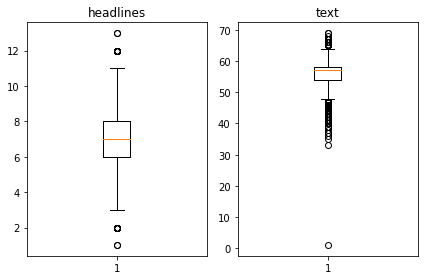

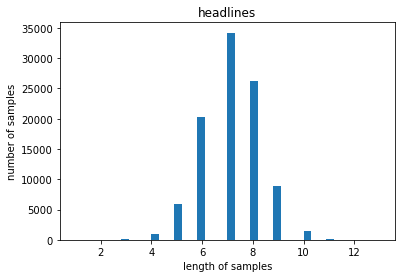

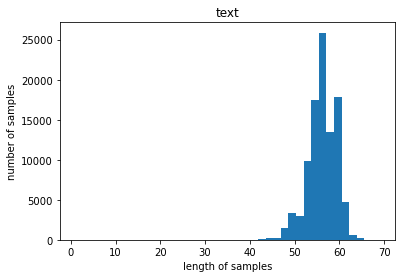

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('텍스트의 최소 길이 : {}'.format(np.min(headlines_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(headlines_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('요약의 최소 길이 : {}'.format(np.min(text_len)))
print('요약의 최대 길이 : {}'.format(np.max(text_len)))
print('요약의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
headlines_max_len = 10
text_max_len = 60

In [14]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
data = data[data['headlines'].apply(lambda x: len(x.split())<=headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split())<=text_max_len)]
print('전체 샘플 수 : ', (len(data)))

전체 샘플 수 :  92737


### 시작 토큰과 종료 토큰 추가하기

In [16]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['text'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['text'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...,sostoken saurav kant an alumnus of upgrad and ...,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken kunal shah credit card bill payment p...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand defeated india by wickets...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken with aegon life iterm insurance plan ...,with aegon life iterm insurance plan customers...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...,sostoken speaking about the sexual harassment ...,speaking about the sexual harassment allegatio...


In [17]:
encoder_input = np.array(data['headlines']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
#encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[27552 16982 44375 ... 27904 42930 73745]


In [19]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
#잘 섞인 샘플 완성

In [20]:
#train 8 : test 2 로 분리하기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18547


In [21]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74190
훈련 레이블의 개수 : 74190
테스트 데이터의 개수 : 18547
테스트 레이블의 개수 : 18547


## (3) 정수 인코딩

In [22]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [23]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29277
등장 빈도가 9번 이하인 희귀 단어의 수: 22045
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7232
단어 집합에서 희귀 단어의 비율: 75.29801550705332
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.703526627218935


In [24]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [25]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4244, 2286, 51, 496, 2038, 2734], [35, 2110, 123, 488, 1832, 79, 3958, 3959, 29], [240, 652, 3620, 5816]]


In [26]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [27]:
threshold = 10
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68088
등장 빈도가 9번 이하인 희귀 단어의 수: 50055
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18033
단어 집합에서 희귀 단어의 비율: 73.51515685583362
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.9117914575598127


In [28]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[11, 158, 10, 35, 507, 834, 891, 2, 35, 154, 68, 506, 83, 44, 29, 768, 215, 18, 1259, 24, 10, 79, 22, 44, 13, 774, 3, 1237, 44, 36, 16, 314, 254, 154, 68, 242, 5, 9, 10, 29, 154, 68, 4, 18, 227, 16, 9, 1975, 94, 43, 131, 253, 88, 1222], [11, 1, 249, 64, 6, 119, 1555, 1, 218, 1014, 4, 153, 3, 1044, 2, 1, 660, 5, 180, 665, 487, 1, 852, 13, 91, 6, 1138, 670, 1, 300, 4, 1, 878, 1184, 5, 37, 153, 80, 273], [11, 642, 5, 408, 368, 7, 518, 578, 8, 1, 4, 329, 376, 3, 1, 65, 360, 1, 4, 424, 150, 329, 289, 4, 31, 376, 25, 233, 7, 9, 1, 822, 4, 38, 23, 749, 39, 32, 1, 233, 36, 1, 472, 1357, 2, 1937, 1, 1459, 4, 1929, 927, 761, 3, 1, 65], [11, 783, 23, 67, 2, 4, 38, 78, 389, 24, 473, 750, 1, 86, 7, 9, 788, 389, 23, 70, 26, 632, 2, 4, 45, 66, 1, 48, 32, 21, 783, 1836, 324, 5, 3, 1, 161, 5, 282, 32, 1836, 14, 203, 2, 783, 778], [11, 1, 77, 166, 64, 7, 632, 32, 56, 572, 30, 13, 979, 2, 35, 1, 623, 5, 35, 333, 37, 1, 15, 1, 257, 5, 55, 37, 53, 1, 1, 250, 1286, 64, 22, 40, 979, 344, 26, 22

In [29]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 74190
훈련 레이블의 개수 : 74190
테스트 데이터의 개수 : 18546
테스트 레이블의 개수 : 18546


### 패딩하기

In [30]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = headlines_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = text_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = text_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = text_max_len, padding='post')

# <모델 설계하기>

In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [32]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [33]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

# Step 3. 어텐션 메커니즘 사용하기

In [34]:
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

## 모델 훈련하기

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
290/290 [==============================] - 71s 244ms/step - loss: 4.3825 - val_loss: 3.9066
Epoch 2/50
290/290 [==============================] - 71s 246ms/step - loss: 3.7250 - val_loss: 3.5415
Epoch 3/50
290/290 [==============================] - 70s 240ms/step - loss: 3.4730 - val_loss: 3.3683
Epoch 4/50
290/290 [==============================] - 70s 242ms/step - loss: 3.3323 - val_loss: 3.2629
Epoch 5/50
290/290 [==============================] - 69s 237ms/step - loss: 3.2374 - val_loss: 3.1845
Epoch 6/50
290/290 [==============================] - 69s 239ms/step - loss: 3.1677 - val_loss: 3.1315
Epoch 7/50
290/290 [==============================] - 69s 237ms/step - loss: 3.1131 - val_loss: 3.0853
Epoch 8/50
290/290 [==============================] - 69s 237ms/step - loss: 3.0675 - val_loss: 3.0465
Epoch 9/50
290/290 [==============================] - 69s 237ms/step - loss: 3.0295 - val_loss: 3.0217
Epoch 10/50
290/290 [==============================] - 69s 237ms/step - l

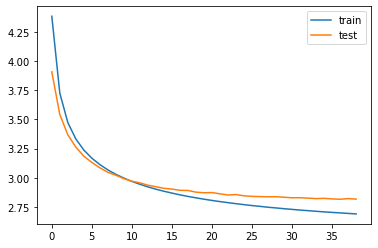

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기

## 인퍼런스 모델 구현하기

In [37]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [38]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [39]:
#어텐션 메커니즘을 사용하는 출력층 설계


# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [40]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## < Test>

In [41]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [42]:
#실제 요약과 예측된 요약 비교하기
for i in range(20, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# Step 5. Summa을 이용해서 추출적 요약해보기

In [43]:
import requests
from summa.summarizer import summarize

In [44]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [45]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
